In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import pyLDAvis.sklearn
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import (
    wordnet,
    stopwords
)
from wordcloud import WordCloud
from textwrap import wrap
import spacy
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import seaborn as sns
#sp=spacy.load('/home/nishant/miniconda3/lib/python3.7/site-packages/en_core_web_sm/en_core_web_sm-2.3.1')
#sp_stopwords = sp.Defaults.stop_words
#lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/kalpesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/kalpesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kalpesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kalpesh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/home/kalpesh/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train=pd.read_csv('Data/train.csv')
train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [3]:
#Cleaning the data
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
#Create a function to clean tweets
lemmatizer = WordNetLemmatizer()

#Create a function to clean tweets
def cleanText(text):
    text=str(text)  #Coverts Text to String
    text=re.sub(r'@[A-Za-z0-9]+','',text)  #Removing @Mentions
    text = re.sub(r'#[\w]*sxsw[\w]*', ' ', text,flags=re.I)  #Removing sxsw hashtag
    text=re.sub(r'#','',text)  #Removing # Symbols
    text=re.sub(r'RT[\s]+','',text)  #Removing ReTweets
    text=re.sub(r'https?:\/\/\s+','',text)  #Removing the hyperlinks
    text=re.sub(r'bit.ly[/\.\w]+','',text)  #Removing the shortlinks 
    text=text.replace(r'{html}',"") 
    cleanr = re.compile(r'<.*?>')
    text = re.sub(cleanr, '', text)
    text = re.sub(r'[0-9]+', '', text)  #Removing Numbers
    text = re.sub(r'[^A-Za-z]+', ' ', text)  #Removing all spacial character
    text = text.lower()  #Coverts Text To Lower Case
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text) 
    lemma_words=[lemmatizer.lemmatize(w) for w in tokens if w not in ['sxsw','amp','quot','http','html','link']]
    return " ".join(lemma_words)

In [4]:
#Cleaning the tweets
train['cleanText']=train['tweet'].map(lambda s:cleanText(s))

In [5]:
train.head()

,tweet_id,tweet,sentiment,cleanText
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,apple defining language of touch with differen...
1,1851,Learning ab Google doodles! All doodles should...,1,learning ab google doodle all doodle should be...
2,2689,one of the most in-your-face ex. of stealing t...,2,one of the most in your face ex of stealing th...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,this iphone app would b pretty awesome if it d...
4,3604,Line outside the Apple store in Austin waiting...,1,line outside the apple store in austin waiting...


In [6]:
train.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
cleanText    0
dtype: int64

In [7]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","would b":"would be"}
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [8]:
train['text']=train['cleanText'].apply(lambda x:expand_contractions(x))

In [9]:
train.head()

,tweet_id,tweet,sentiment,cleanText,text
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,apple defining language of touch with differen...,apple defining language of touch with differen...
1,1851,Learning ab Google doodles! All doodles should...,1,learning ab google doodle all doodle should be...,learning ab google doodle all doodle should be...
2,2689,one of the most in-your-face ex. of stealing t...,2,one of the most in your face ex of stealing th...,one of the most in your face ex of stealing th...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,this iphone app would b pretty awesome if it d...,this iphone app would be pretty awesome if it ...
4,3604,Line outside the Apple store in Austin waiting...,1,line outside the apple store in austin waiting...,line outside the apple store in austin waiting...


In [10]:
nlp = spacy.load('en_core_web_lg',disable=['parser', 'ner'])
# Lemmatization with stopwords removal
train['lemmatized']=train['text'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
train.head()

,tweet_id,tweet,sentiment,cleanText,text,lemmatized
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,apple defining language of touch with differen...,apple defining language of touch with differen...,apple define language touch different dialect ...
1,1851,Learning ab Google doodles! All doodles should...,1,learning ab google doodle all doodle should be...,learning ab google doodle all doodle should be...,learning ab google doodle doodle light funny i...
2,2689,one of the most in-your-face ex. of stealing t...,2,one of the most in your face ex of stealing th...,one of the most in your face ex of stealing th...,face ex steal yr apple school mkt expert link
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,this iphone app would b pretty awesome if it d...,this iphone app would be pretty awesome if it ...,iphone app pretty awesome didn t crash min ext...
4,3604,Line outside the Apple store in Austin waiting...,1,line outside the apple store in austin waiting...,line outside the apple store in austin waiting...,line outside apple store austin wait new ipad ...


In [11]:
train.nunique()

tweet_id      7274
tweet         7255
sentiment        4
cleanText     6061
text          6061
lemmatized    5923
dtype: int64

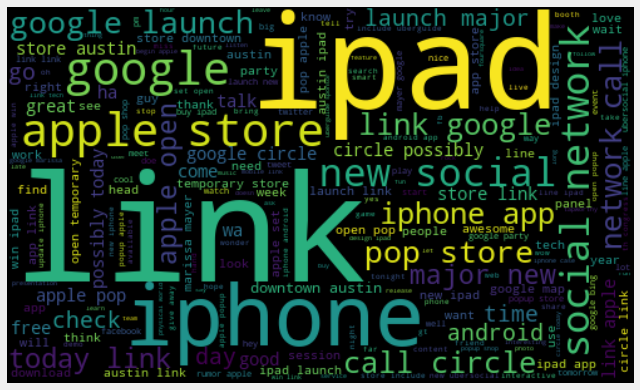

In [12]:
#Plot the WordCloud
plt.figure(figsize=(10,15))
allWords=' '.join([twts for twts in train['lemmatized']])
wordCloud= WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
train['sentiment'] = train['lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)
train.head()

,tweet_id,tweet,sentiment,cleanText,text,lemmatized
0,1701,#sxswnui #sxsw #apple defining language of tou...,-0.125000,apple defining language of touch with differen...,apple defining language of touch with differen...,apple define language touch different dialect ...
1,1851,Learning ab Google doodles! All doodles should...,0.381250,learning ab google doodle all doodle should be...,learning ab google doodle all doodle should be...,learning ab google doodle doodle light funny i...
2,2689,one of the most in-your-face ex. of stealing t...,0.000000,one of the most in your face ex of stealing th...,one of the most in your face ex of stealing th...,face ex steal yr apple school mkt expert link
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.625000,this iphone app would b pretty awesome if it d...,this iphone app would be pretty awesome if it ...,iphone app pretty awesome didn t crash min ext...
4,3604,Line outside the Apple store in Austin waiting...,0.068182,line outside the apple store in austin waiting...,line outside the apple store in austin waiting...,line outside apple store austin wait new ipad ...


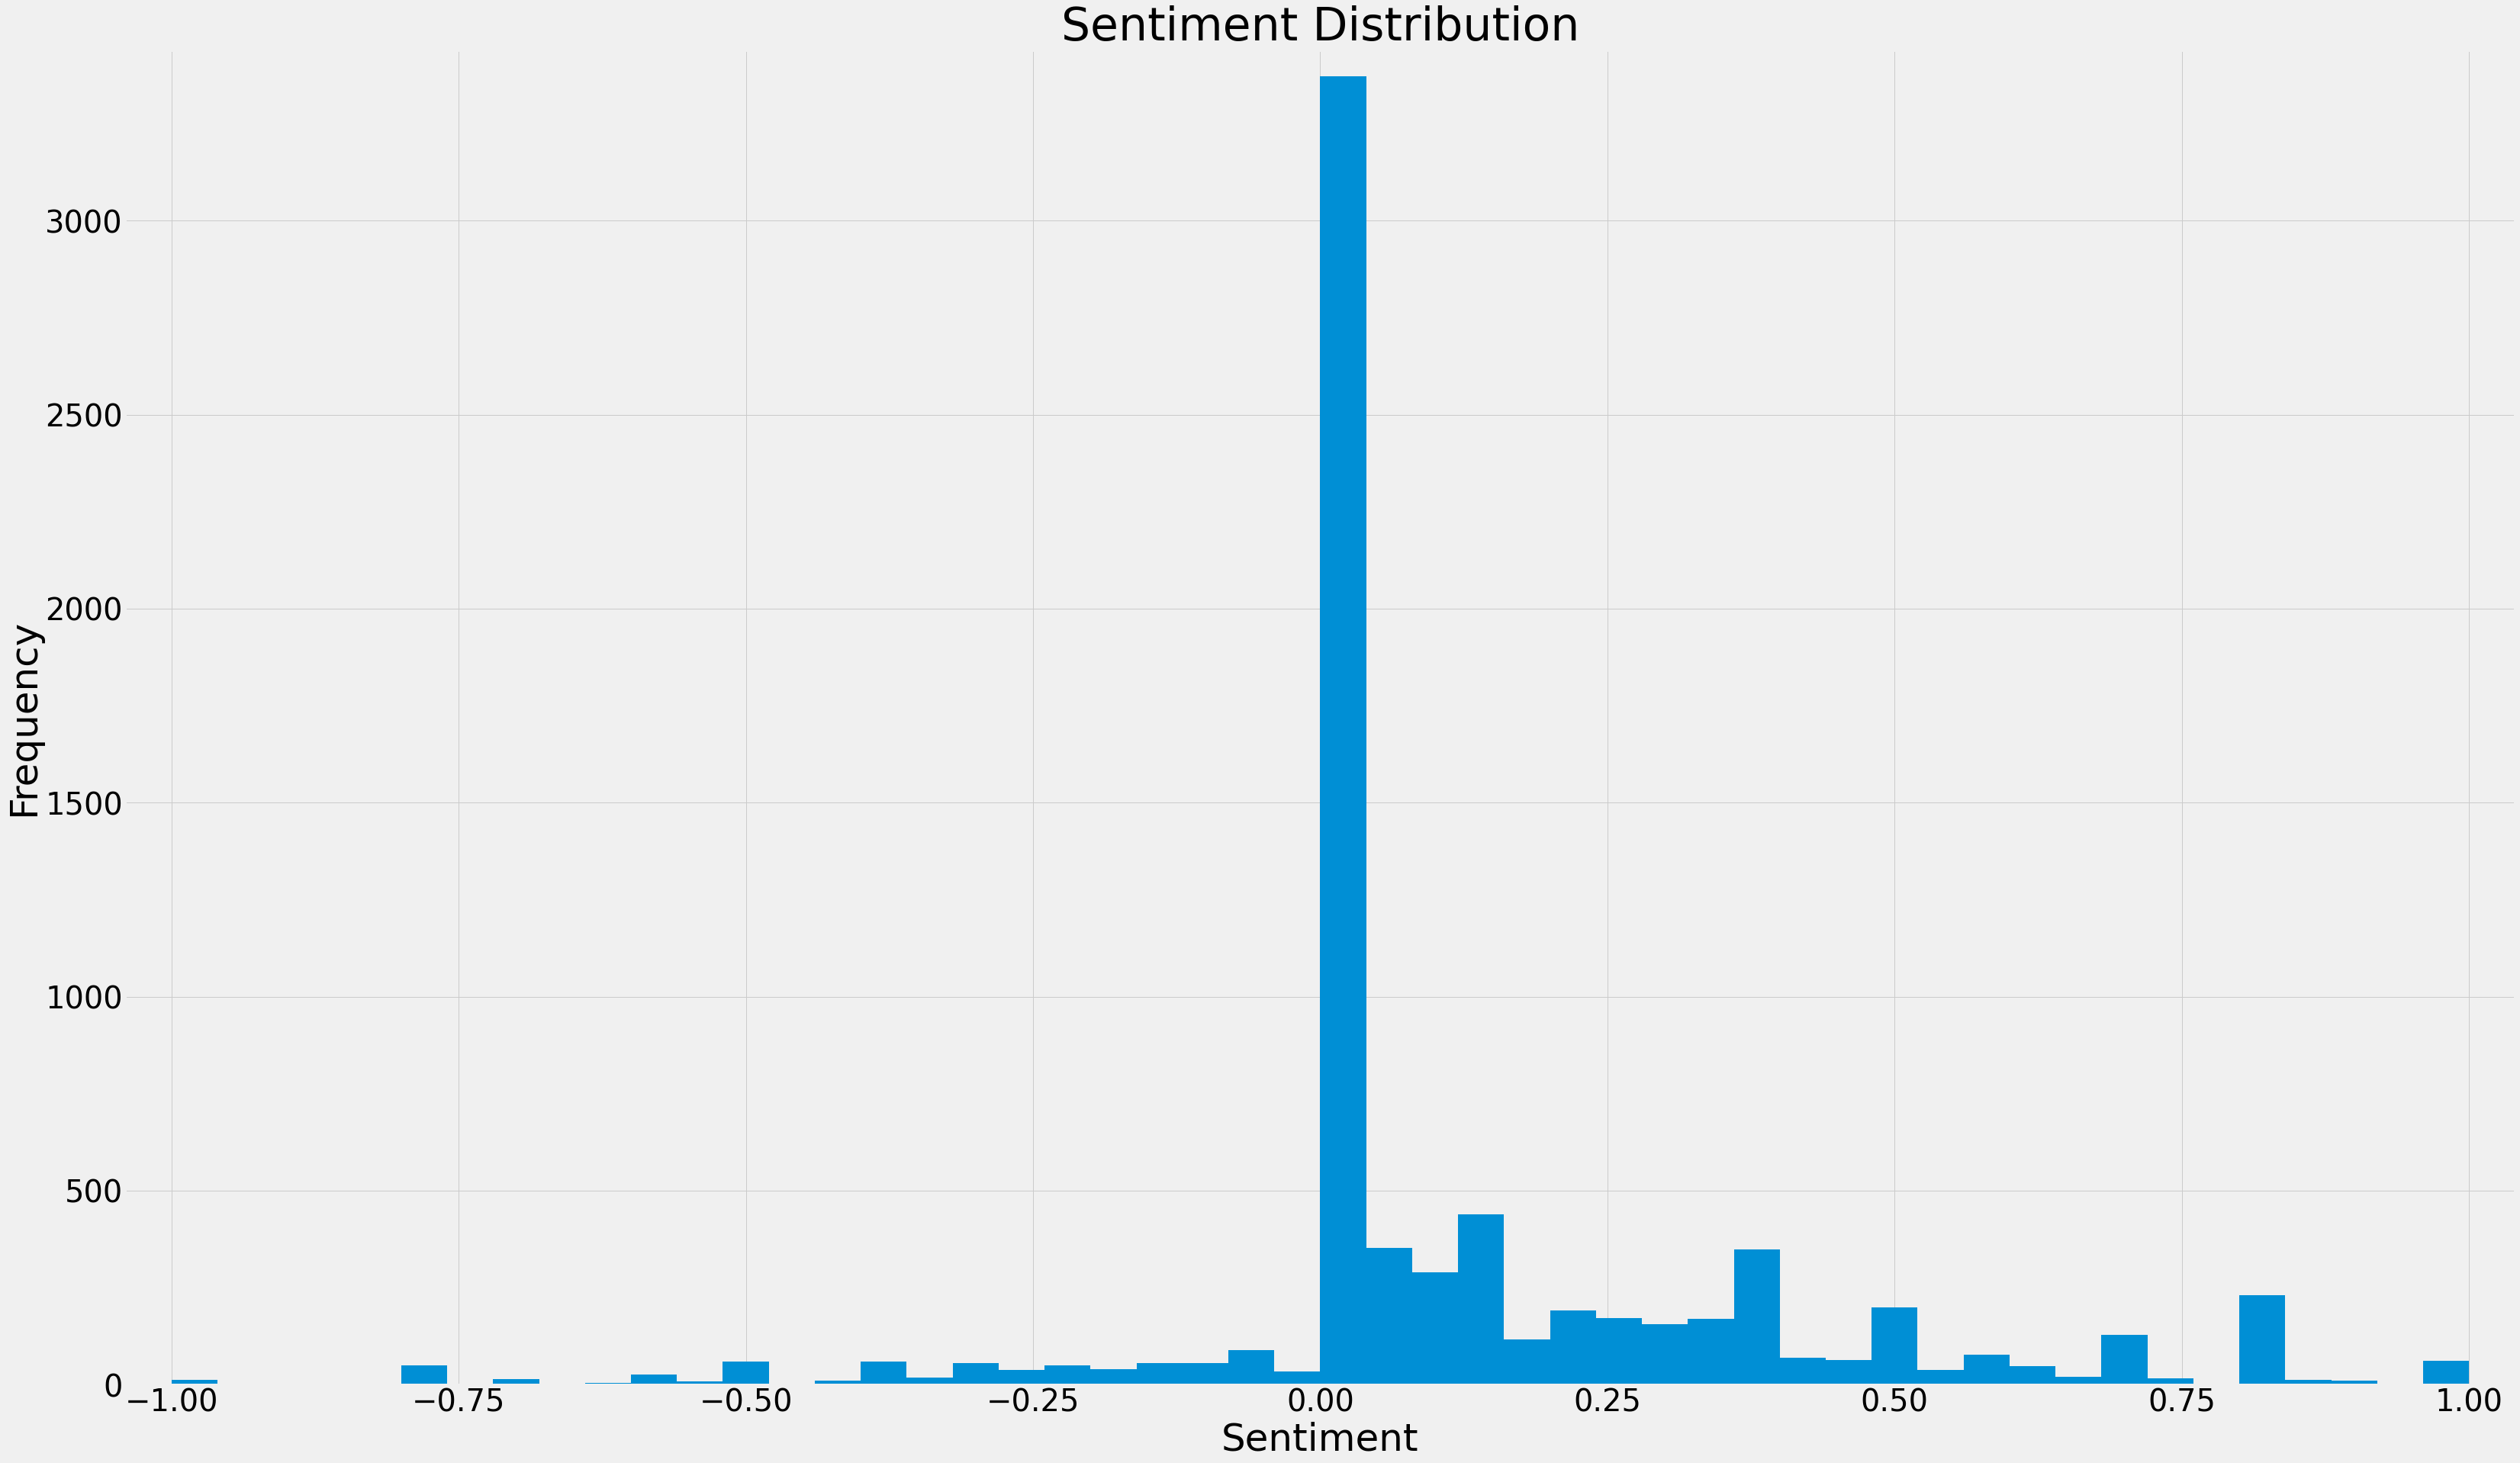

In [14]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(train['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

In [15]:
train['word_count'] = train['lemmatized'].apply(lambda x: len(str(x).split()))
train['review_len'] = train['lemmatized'].astype(str).apply(len)

In [16]:
train.head()

,tweet_id,tweet,sentiment,cleanText,text,lemmatized,word_count,review_len
0,1701,#sxswnui #sxsw #apple defining language of tou...,-0.125000,apple defining language of touch with differen...,apple defining language of touch with differen...,apple define language touch different dialect ...,7,51
1,1851,Learning ab Google doodles! All doodles should...,0.381250,learning ab google doodle all doodle should be...,learning ab google doodle all doodle should be...,learning ab google doodle doodle light funny i...,12,99
2,2689,one of the most in-your-face ex. of stealing t...,0.000000,one of the most in your face ex of stealing th...,one of the most in your face ex of stealing th...,face ex steal yr apple school mkt expert link,9,45
3,4525,This iPhone #SXSW app would b pretty awesome i...,0.625000,this iphone app would b pretty awesome if it d...,this iphone app would be pretty awesome if it ...,iphone app pretty awesome didn t crash min ext...,12,79
4,3604,Line outside the Apple store in Austin waiting...,0.068182,line outside the apple store in austin waiting...,line outside the apple store in austin waiting...,line outside apple store austin wait new ipad ...,9,50


In [17]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(train['lemmatized'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

,access,aclu,action,amazing,android,announce,app,apple,art,artist,...,wifi,will,win,wish,wonder,work,world,wow,year,yes
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7272,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train.drop(columns=['tweet','cleanText','text'], axis=1, inplace=True)

In [19]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
google mobile link map mayer popup marissa location head tech
Topic 1:
ipad like iphone think don work awesome want case com
Topic 2:
google look great link search panel pm hey bing interesting
Topic 3:
google link circle social launch new today network call major
Topic 4:
apple store ipad link austin pop open line day launch
Topic 5:
check good temporary wa need thing rumor link hear give
Topic 6:
android link app iphone go downtown come cool love new
Topic 7:
link party ipad win google get thank japan facebook twitter
Topic 8:
link iphone app free ipad austin ha music time find
Topic 9:
ipad iphone new design people app link talk year tweet


In [20]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  19.176730
3       0.648955  71.707100       2        1  13.929766
9      71.019684   9.971006       3        1  10.489245
8       3.785981  33.185135       4        1  10.420739
6     -42.666500  -9.222070       5        1   9.176187
0      -3.621689 -43.526516       6        1   8.487513
7      -3.632402  -4.171708       7        1   7.696473
1     -36.584400  35.804413       8        1   7.562465
2      44.391380  50.615383       9        1   6.809554
5      40.235809 -31.591665      10        1   6.251328, topic_info=       Term         Freq        Total Category  logprob  loglift
7     apple  1763.000000  1763.000000  Default  30.0000  30.0000
131  google  2148.000000  2148.000000  Default  29.0000  29.0000
173    ipad  2379.000000  2379.000000  Default  28.0000  28.0000
335   store  1154.000000  1154.000000  Default  27.0000  27.0000
174  iphone  1273.000000  1273.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
147    hear    69.695469   125.889318  Topic10  -3.6988   2.1811
127    give    60.629572   107.214199  Topic10  -3.8382   2.2023
199     lot    44.438330    72.234895  Topic10  -4.1489   2.2866
190    link    91.205262  3390.603297  Topic10  -3.4299  -0.8433
392    want    33.388364   161.566612  Topic10  -4.4348   1.1957

[412 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         6  0.974138   access
1         7  0.981975     aclu
2         6  0.978565   action
3         6  0.980849  amazing
4         5  0.997125  android
...     ...       ...      ...
407       6  0.986100    world
408      10  0.980944      wow
409       3  0.991369     year
410       4  0.112112      yes
410       9  0.864862      yes

[415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 10, 9, 7, 1, 8, 2, 3, 6])

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(train['lemmatized'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,access,aclu,action,amazing,android,announce,app,apple,art,artist,...,wifi,will,win,wish,wonder,work,world,wow,year,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.257507,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.282309,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.217378,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7270,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7271,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318566,0.0
7272,0.0,0.0,0.0,0.0,0.0,0.0,0.357575,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [22]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
apple store pop line popup congress sell shop long opening
Topic 1:
circle social network launch new call today major possibly google
Topic 2:
iphone game time case go will battery get use need
Topic 3:
ipad design buy line new need get look ha video
Topic 4:
google map mayer mobile marissa circle search user bing location
Topic 5:
link free check itunes video music news big code sampler
Topic 6:
austin open temporary downtown launch store rumor apple set temp
Topic 7:
app android new mobile check download include ubersocial uberguide update
Topic 8:
party android like good google industry gsdm aclu awesome free
Topic 9:
win begin come apple thank case booth want chance free


In [23]:
nmf_topic_values = nmf.transform(tfidf)
train['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
train['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'Good Design Processes', 1: 'Great Work Environment', 2: 'Flexible Work Hours', 3: 'Skill Building', 4: 'Difficult but Enjoyable Work', 5: 'Great Company/Job', 6: 'Care about Employees', 7: 'Great Contractor Pay', 8: 'Customer Service', 9: 'Unknown1'}
train['lda_topics'] = train['lda_topics'].map(lda_remap)
nmf_remap = {0: 'apple store pop line popup congress sell shop long block', 1: 'circle social network launch new call today major possibly google', 2: 'iphone game case time go battery get charger use know', 3: 'ipad win design buy line new get need guy look', 
             4: 'google map mayer mobile marissa circle search user bing location', 5: 'rt come sxswi japan win cool don product hear conference', 6: 'link free check sxswi video music code begin sampler win', 7: 'austin open temporary downtown store launch rumor apple set temp', 
             8: 'app android new mobile check download include uberguide ubersocial update', 9: 'app android new mobile check download include uberguide ubersocial update'}
train['nmf_topics'] = train['nmf_topics'].map(nmf_remap)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 <a list of 8 Text major ticklabel objects>)

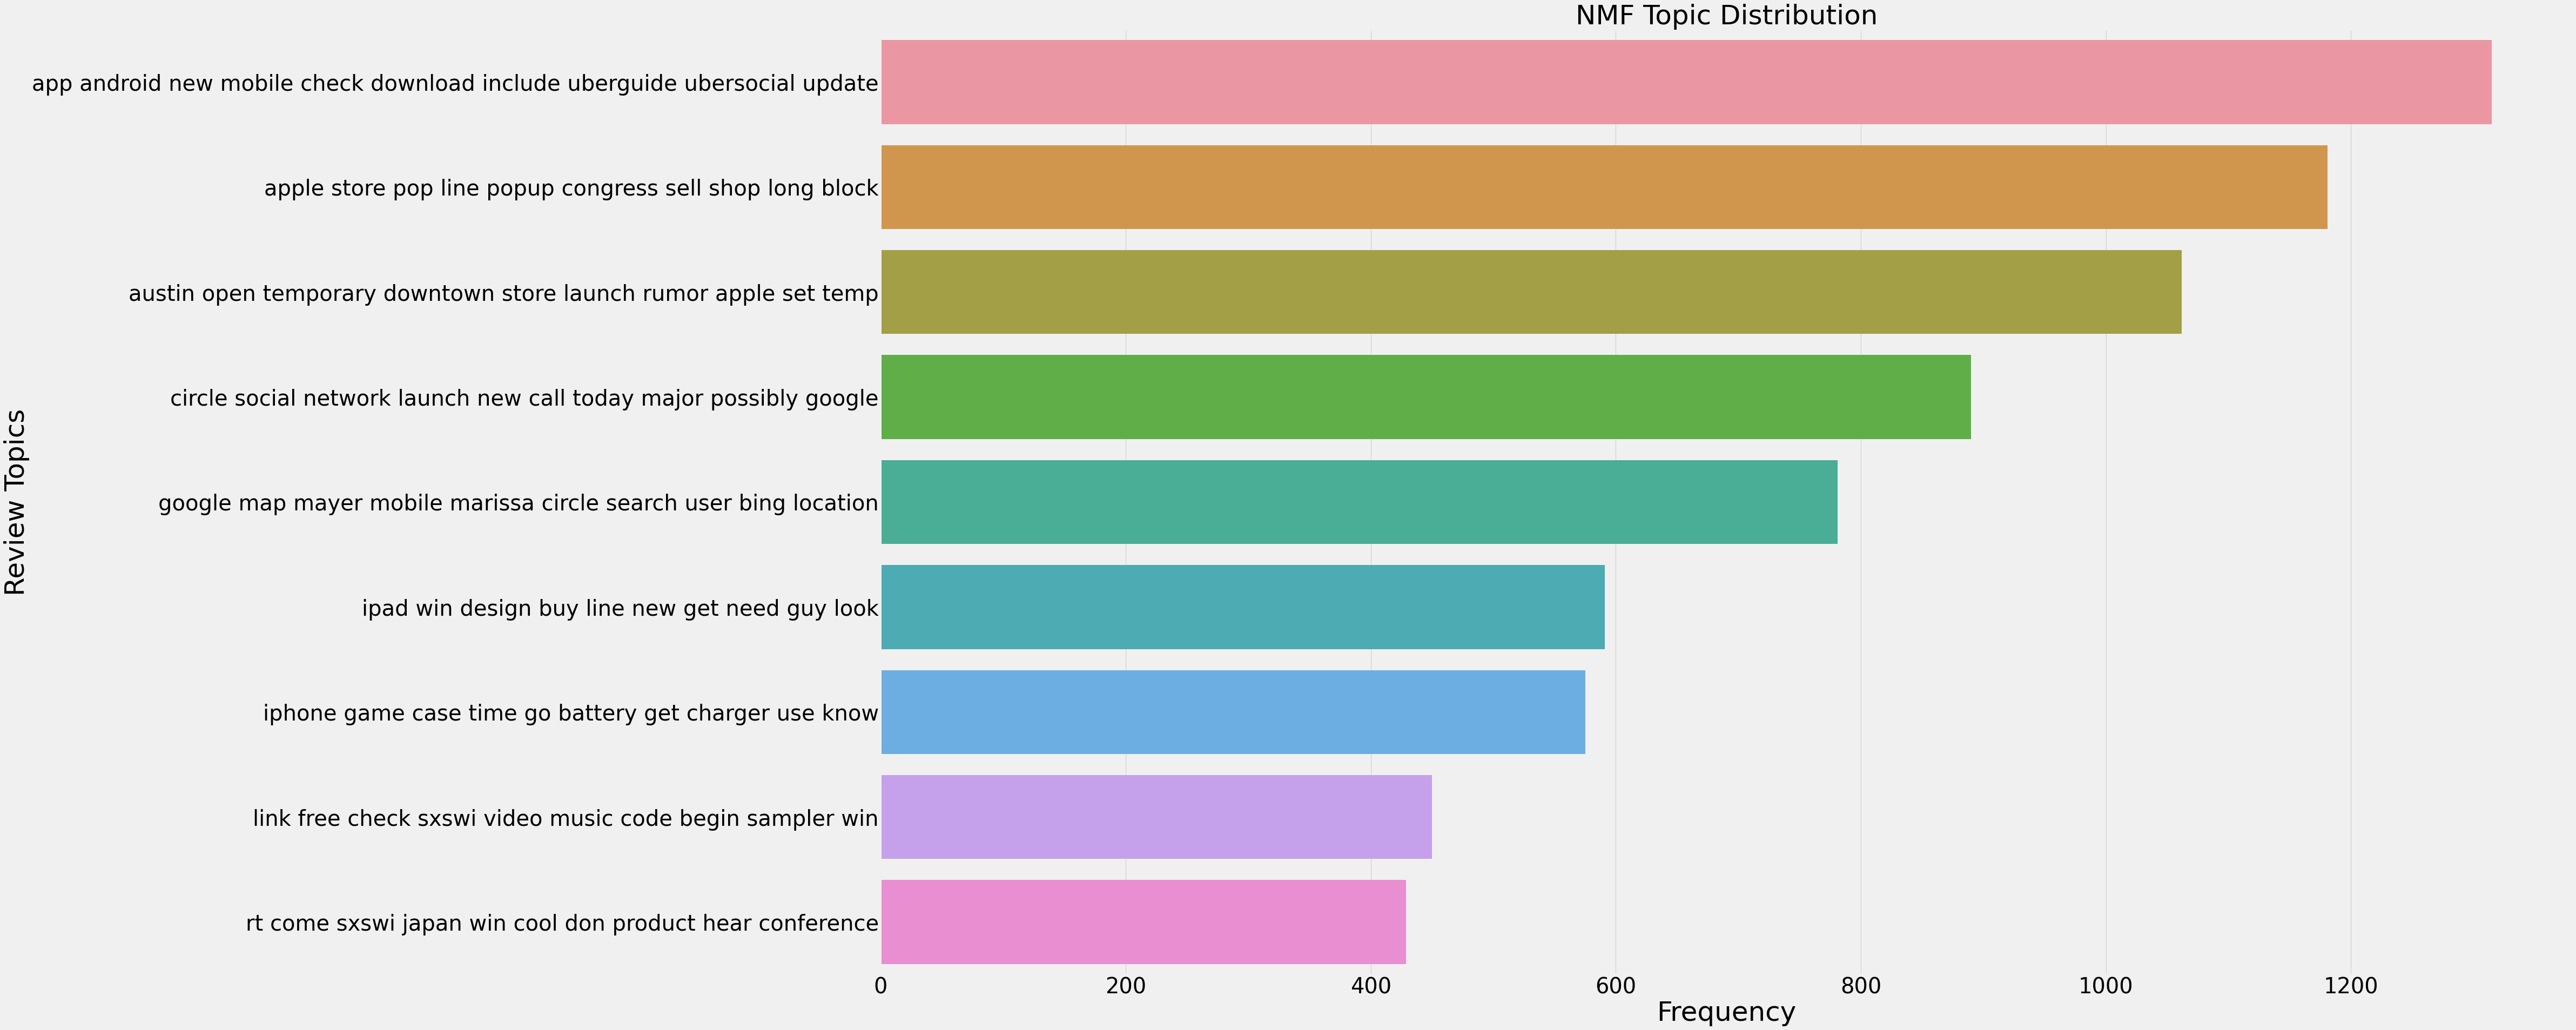

In [24]:
nmf_x = train['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)